# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Notebook created for the guided project [Detecting COVID-19 with Chest X Ray using PyTorch](https://www.coursera.org/projects/covid-19-detection-x-ray) on Coursera

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.5.1


# Preparing Training and Test Sets

In [2]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [3]:
class ChestXrayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform): #transform is used fo rdatat agumemtation
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')] #the image directory will be the dictionary which will have the location or path for the 3 directories of covid, normal and viral of 
            # So the file name dot lower and if that ends with png then we will png then we will know thats the image from the data set
            
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for c in self.class_names:
            self.images[c]= get_images(c) #in dictionary keys(it's values)
            
        self.image_dirs = image_dirs
        self.transform =  transform # to see if it transforms
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names]) # c will iterate over class names covid, viral.. self.images dictionary with keys class name will give us list of images corresponding to that key and length of that. and all the lengths will be added to it
    

    def __getitem__(self, index):
        # one of the problem we might face, # of covid images are less than viral and normal..so, wild training to avid class imbalance, we can actually randoml select which class we wwant to  return...the indec might be out of bound becasue the total length of this dataset is much larger than the individual image list for these 3 classes
        # we will handle this by using not the index value itself but by using the remainder of the index when its divided by the number of images we have for that class
        
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name]) #this step is just to acoid any out of bound index value
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB') #Image is imported from PIL.. since these images are black n white we are converting them to RGB
        return self.transform(image), self.class_names.index(class_name)
    
# getitem will return the transformed image

# Image Transformations

In [4]:
# we will create two trnasformed objects - 1 for the training set and one for the test set

# TRAINING SET

train_transform = torchvision.transforms.Compose([
    # we need to 1st convert that model into the size that it expects
    
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    
    # doing the RandomHorizontalFlip doesn't actually change the class but can be used to agument our data
    # next we will convert image to Tensor so that it can be used in computation by pyTorch
    #fianally we will normalize the data,.. we need to normalize it to a specific range which is used when this  model was trained on imagenet data set
    # we need to ensure that our input data is normalized in the same way that the imagenet data set is normalized.
    
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485,0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

# we can pretty much do the same thing for the test set but the difference will be we don't do data agumentation in the test set or in the validitation set..apatt from this everything will be the same

In [5]:
# TEST SET

test_transform = torchvision.transforms.Compose([
    # we need to 1st convert that model into the size that it expects
    
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485,0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [6]:
# Before we start working on the models we need to do prepare DataLoaders
#DataLoaders are essentially either maps or Python iterators which are going to use the dataset onjects in example and give it to the model during the cleaning process

In [7]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}

train_dataset = ChestXrayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 189 covid examples


In [8]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}

test_dataset = ChestXrayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [9]:
# now inorder to create our datatloader we have to use the dataloader class from the data module in PyTorch utilities

batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size,
                                      shuffle= True)
# Thus the indicies are suffled and the examples will not be sequentially picked

dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size,
                                     shuffle= True)

#lets look at the number of batches we have created

print('Num of training batches', len(dl_train))
print('Num of test batches', len(dl_test))

Num of training batches 470
Num of test batches 15


# Data Visualization

In [10]:
# here we will look at some of the examples and we will create a helper function to display images that we will also use later in our training loop

class_names = train_dataset.class_names

def show_images(images, labels, preds): # preds - prediction
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1,  xticks=[], yticks=[])
        image = image.numpy().transpose((1,2,0)) # transposed the subplots
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'     
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)
    plt.tight_layout()
    plt.show()
    

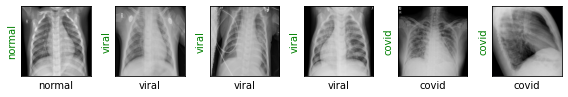

In [11]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

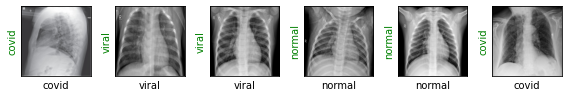

In [12]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [13]:
resnet18 = torchvision.models.resnet18(pretrained = True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn= torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

# if we wonder what learning rate(lr) you should use then, it is more based on hit and trail

In [15]:
def show_preds(): # this will show us predictions from resnet18 model
    resnet18.eval()
    images, labels= next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1) # torch.max() returns those values as well as the indices but we only want indices not values and te values will serve as predictions 
    # dimension 0 will correspond to number of examples so, we are looking at dimention 1 which are the output values
    show_images(images, labels, preds)

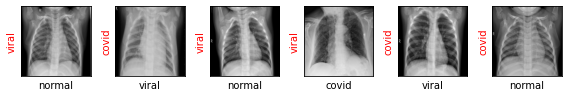

In [16]:
show_preds()

# we have the model here but it is not trained yet so we will train it in next step

# Training the Model

In [17]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)
        
        train_loss = 0
        
        resnet18.train()
        
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                acc = 0.
                val_loss = 0.
                resnet18.eval()
                
                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    _, preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).numpy())
                val_loss /= (val_step + 1) # diving by total number of steps.. value we get is for each step
                acc = acc / len(test_dataset)
                print(f'Val loss: {val_loss:.4f}, Acc: {acc:4f}')
                show_preds()
                
                resnet18.train()
                
                if acc > 0.95:
                    print('Performance condition satisfied..')
                    return
        train_loss /= (train_step + 1)
        print(f'Training loss: {train_loss:.4f}')
                    
                    

Starting training..
Starting epoch 1/1
Evaluating at step 0
Val loss: 1.2141, Acc: 0.266667


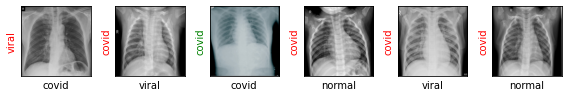

Evaluating at step 20
Val loss: 0.7158, Acc: 0.711111


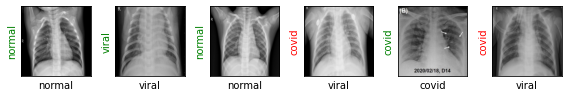

Evaluating at step 40
Val loss: 0.3393, Acc: 0.822222


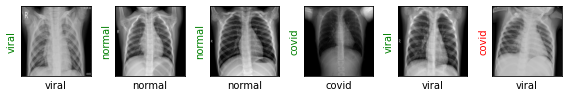

Evaluating at step 60
Val loss: 0.1677, Acc: 0.955556


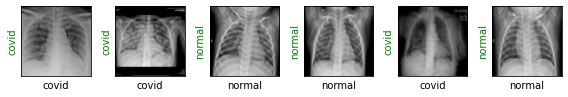

Performance condition satisfied..


In [18]:
train(epochs=1)

# Final Results

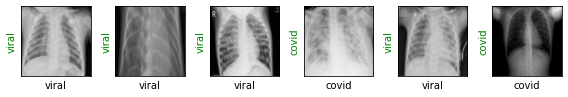

In [19]:
show_preds()